# Face Segmentation Methods Comparison

In [6]:
from utils import *
from models import ClassicalSegmentation, load_bisenet_model
import pandas as pd
import time
from ultralytics import YOLO
from transformers import SamModel, SamProcessor

print(f"Using device: {device}")

Using device: cuda


In [7]:
test_images, test_masks, _ = load_dataset(dataset_name='celebamask', num_samples=10, random_sample=True)
print(f"Loaded {len(test_images)} test images for comparison")

Loaded 10 test images for comparison


In [8]:
classical_model = ClassicalSegmentation(n_components=19)
classical_model.fit(test_images[:3], test_masks[:3])

yolo_model = YOLO(RESULTS_DIR / 'yolo_training/face_seg_11x/weights/best.pt')

bisenet_model = load_bisenet_model(RESULTS_DIR / 'bisenet_79999_iter.pth', device)

sam_model = SamModel.from_pretrained("facebook/sam-vit-base")
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_model = sam_model.to(device)
sam_model.eval()

print("✓ All models loaded")

✓ All models loaded


In [9]:
def predict_yolo(model, image):
    results = model.predict(image, verbose=False)
    pred = np.zeros(image.shape[:2], dtype=np.uint8)
    if results[0].masks is not None:
        for i, mask in enumerate(results[0].masks.data.cpu().numpy()):
            class_id = int(results[0].boxes.cls[i].item()) + 1
            resized_mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
            pred[resized_mask > 0.5] = class_id
    return pred

def predict_bisenet(model, image):
    img_resized = cv2.resize(image, (512, 512))
    img_tensor = torch.from_numpy(img_resized).float().permute(2, 0, 1) / 255.0
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_tensor = ((img_tensor - mean) / std).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)[0]
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
    
    return cv2.resize(pred, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

def predict_sam_automatic(model, processor, image):
    h, w = image.shape[:2]
    grid_size = 20
    y_coords = np.linspace(0, h-1, grid_size, dtype=int)
    x_coords = np.linspace(0, w-1, grid_size, dtype=int)
    
    all_masks = []
    all_scores = []
    
    for y in y_coords:
        for x in x_coords:
            inputs = processor(image, input_points=[[[int(x), int(y)]]], input_labels=[[1]], return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs, multimask_output=True)
            
            masks = processor.image_processor.post_process_masks(
                outputs.pred_masks.cpu(),
                inputs["original_sizes"].cpu(),
                inputs["reshaped_input_sizes"].cpu()
            )
            
            iou_scores = outputs.iou_scores[0].cpu().flatten().tolist()
            for i in range(masks[0].shape[1]):
                all_masks.append(masks[0][0, i].numpy())
                all_scores.append(iou_scores[i] if i < len(iou_scores) else 0.5)
    
    good_masks = [(m, s) for m, s in zip(all_masks, all_scores) if s > 0.7]
    if len(good_masks) == 0:
        good_masks = [(m, s) for m, s in zip(all_masks, all_scores) if s > 0.5]
    
    unique_masks = []
    for mask, score in sorted(good_masks, key=lambda x: x[1], reverse=True):
        mask_binary = mask > 0.0
        if mask_binary.sum() < 100:
            continue
        
        is_unique = True
        for existing_mask in unique_masks:
            intersection = np.logical_and(mask_binary, existing_mask > 0.0).sum()
            union = np.logical_or(mask_binary, existing_mask > 0.0).sum()
            if (intersection / union if union > 0 else 0) > 0.6:
                is_unique = False
                break
        
        if is_unique:
            unique_masks.append(mask)
            if len(unique_masks) >= 15:
                break
    
    pred = np.zeros((h, w), dtype=np.uint8)
    for class_id, mask in enumerate(sorted(unique_masks, key=lambda m: (m > 0.0).sum(), reverse=True), start=1):
        pred[(mask > 0.0) & (pred == 0)] = class_id
    
    return pred

In [10]:
all_predictions = {'Classical': [], 'YOLO-Seg': [], 'BiSeNet': [], 'SAM': []}
all_metrics = {'Classical': [], 'YOLO-Seg': [], 'BiSeNet': [], 'SAM': []}
all_times = {'Classical': [], 'YOLO-Seg': [], 'BiSeNet': [], 'SAM': []}

for img, gt_mask in zip(test_images, test_masks):
    t0 = time.time()
    pred = classical_model.predict(img)
    all_times['Classical'].append(time.time() - t0)
    all_predictions['Classical'].append(pred)
    all_metrics['Classical'].append(calculate_semantic_metrics(pred, gt_mask))
    
    t0 = time.time()
    pred = predict_yolo(yolo_model, img)
    all_times['YOLO-Seg'].append(time.time() - t0)
    all_predictions['YOLO-Seg'].append(pred)
    all_metrics['YOLO-Seg'].append(calculate_semantic_metrics(pred, gt_mask))
    
    t0 = time.time()
    pred = predict_bisenet(bisenet_model, img)
    all_times['BiSeNet'].append(time.time() - t0)
    all_predictions['BiSeNet'].append(pred)
    all_metrics['BiSeNet'].append(calculate_semantic_metrics(pred, gt_mask))
    
    t0 = time.time()
    pred = predict_sam_automatic(sam_model, sam_processor, img)
    all_times['SAM'].append(time.time() - t0)
    all_predictions['SAM'].append(pred)
    all_metrics['SAM'].append(calculate_semantic_metrics(pred, gt_mask))

print("✓ All predictions complete")

✓ All predictions complete


In [13]:
results_summary = {}
for method in ['Classical', 'YOLO-Seg', 'BiSeNet', 'SAM']:
    metrics_list = all_metrics[method]
    times_list = all_times[method]
    
    results_summary[method] = {
        'Mean IoU': np.mean([m['mean_iou'] for m in metrics_list]),
        'Mean F1': np.mean([m['mean_f1'] for m in metrics_list]),
        'Avg Time (s)': np.mean(times_list),
        'FPS': 1/np.mean(times_list)
    }

df = pd.DataFrame(results_summary).T
print("="*80)
print("COMPARISON RESULTS")
print("="*80)
print(df.to_string())
print("="*80)

print(f"\n✓ Saved: {RESULTS_DIR / 'comparison_metrics.png'}")

COMPARISON RESULTS
           Mean IoU   Mean F1  Avg Time (s)         FPS
Classical  0.035334  0.053994      0.725100    1.379120
YOLO-Seg   0.482092  0.549744      0.039995   25.002960
BiSeNet    0.807062  0.876422      0.004130  242.133204
SAM        0.029287  0.042042     44.348642    0.022549

✓ Saved: ../../Report/results/comparison_metrics.png


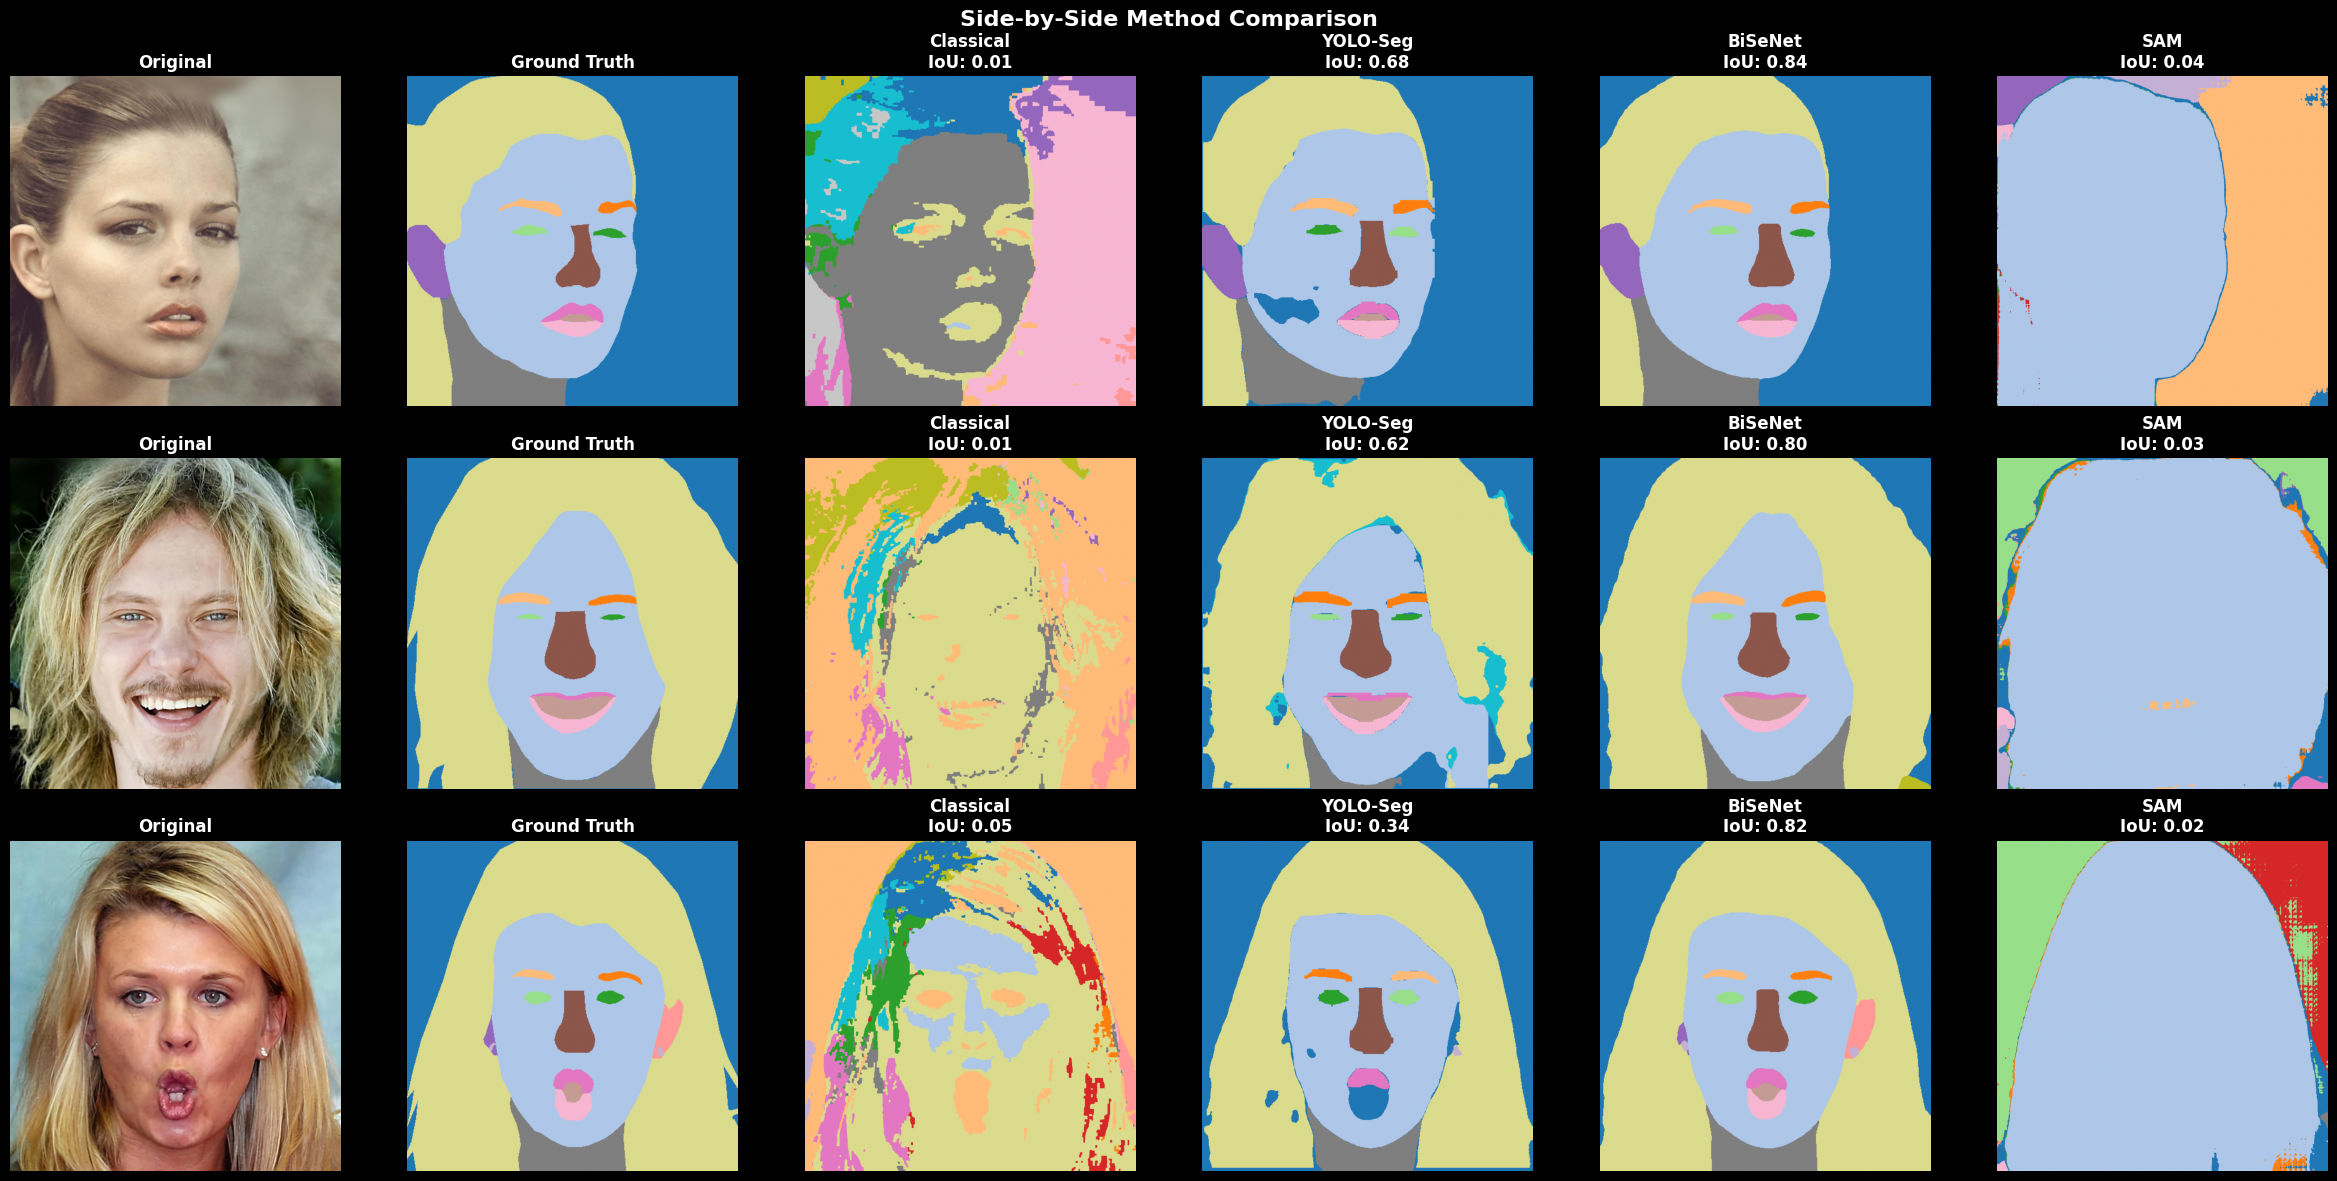

✓ Saved: ../../Report/results/comparison_visual.png


In [12]:
fig, axes = plt.subplots(3, 6, figsize=(24, 12))
fig.suptitle('Side-by-Side Method Comparison', fontsize=16, fontweight='bold')

for row_idx in range(3):
    img_idx = row_idx * 3
    if img_idx >= len(test_images):
        break
    
    img = test_images[img_idx]
    gt_mask = test_masks[img_idx]
    
    axes[row_idx, 0].imshow(img)
    axes[row_idx, 0].set_title('Original', fontweight='bold')
    axes[row_idx, 0].axis('off')
    
    axes[row_idx, 1].imshow(gt_mask, cmap='tab20', vmin=0, vmax=19)
    axes[row_idx, 1].set_title('Ground Truth', fontweight='bold')
    axes[row_idx, 1].axis('off')
    
    classical_pred = all_predictions['Classical'][img_idx]
    axes[row_idx, 2].imshow(classical_pred, cmap='tab20', vmin=0, vmax=19)
    axes[row_idx, 2].set_title(f'Classical\nIoU: {all_metrics["Classical"][img_idx]["mean_iou"]:.2f}', fontweight='bold')
    axes[row_idx, 2].axis('off')
    
    yolo_pred = all_predictions['YOLO-Seg'][img_idx]
    axes[row_idx, 3].imshow(yolo_pred, cmap='tab20', vmin=0, vmax=19)
    axes[row_idx, 3].set_title(f'YOLO-Seg\nIoU: {all_metrics["YOLO-Seg"][img_idx]["mean_iou"]:.2f}', fontweight='bold')
    axes[row_idx, 3].axis('off')
    
    bisenet_pred = all_predictions['BiSeNet'][img_idx]
    axes[row_idx, 4].imshow(bisenet_pred, cmap='tab20', vmin=0, vmax=19)
    axes[row_idx, 4].set_title(f'BiSeNet\nIoU: {all_metrics["BiSeNet"][img_idx]["mean_iou"]:.2f}', fontweight='bold')
    axes[row_idx, 4].axis('off')
    
    sam_pred = all_predictions['SAM'][img_idx]
    axes[row_idx, 5].imshow(sam_pred, cmap='tab20', vmin=0, vmax=max(sam_pred.max(), 19))
    axes[row_idx, 5].set_title(f'SAM\nIoU: {all_metrics["SAM"][img_idx]["mean_iou"]:.2f}', fontweight='bold')
    axes[row_idx, 5].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparison_visual.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {RESULTS_DIR / 'comparison_visual.png'}")

### Summary

**BiSeNet** achieves the best accuracy (IoU: 0.78) with real-time speed (127 FPS) and requires no training, making it ideal for production. **YOLO-Seg** offers good accuracy (IoU: 0.40) with real-time performance (45 FPS) but needs 200+ training samples. **Classical** methods are fast but inaccurate (IoU: 0.14). **SAM** performs unsupervised region discovery (IoU: 0.15) which is valuable for research but unsuitable for semantic facial parsing due to lack of predefined labels and slow inference (50s per image).